# Hii!
This notebook is my solution to the **Specific Test III. Learning Mass of Dark Matter Halo**. In this notebook I've Implement the regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass, I have clearly explained all the code cell's.

*contents*
1. Importing libraries and extracting files
2. Custom Dataset
3. Model() class
4. Training and evaluating
5. Visualising Metrics

In [ ]:
#createing best_regression_model in the working directory 
!mkdir best_regression_model

# **1. Importing Libraries**


In [ ]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.utils.data import  Dataset  , DataLoader
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

device =  'cuda' if torch.cuda.is_available() else 'cpu'   #setting device 
PATH = "/kaggle/input/mlscidataset/lens_data_alt.tgz"   #directory path in which dataset is stored in .tgz format
!tar -xvf /kaggle/input/mlscidataset/lens_data_alt.tgz   #loading the files in the working directory
bestmodel_path = '/kaggle/working/best_regression_model/regression_model.pth' 

_ , _ , npy_files_paths = next(os.walk("/kaggle/working/lens_data"))   #walking through all the sub files
random.shuffle(npy_files_paths)

# 2. Custom Dataset

Here i've first defined transformations and then I created a 'CustomDataset' which loads the images as a torchTensor along with there masses as a tuple.

In [32]:
def transformation(image):
    
    transform = transforms.Compose(
    
                  [transforms.RandomHorizontalFlip(0.5),
                   transforms.RandomVerticalFlip(0.5),
                   transforms.Normalize( mean = 45 , std = 55 )
                  ]
                                )
    image = transform(image)
    return image

In [33]:
class CustomDataset(Dataset):
    
    def __init__(self , npy_files_paths , dataset = 'val'):
        self.files = npy_files_paths
        self.dataset = dataset
    def __len__(self):
        length = len(self.files)
        return length

    def __getitem__(self , id):
        path = "/kaggle/working/lens_data/" # path of lens-dataset 
        file = path + self.files[id] 
        data = np.load( file = file , allow_pickle = True) #loading the numpy array
        x , y = data[0] , data[1]
        image = torch.from_numpy(x)
        image = torch.reshape(image , ( 1, 150 , 150))
        image = image.type(torch.FloatTensor)

        if self.dataset == 'train':
            image = transformation(image)
        else:
            transform = transforms.Compose([
                   transforms.Normalize( mean = 45 , std = 55 )]
                                )
            image = transform(image)
        mass = y
        return image , mass # returns image as a Tensor of shape( 1, 150 , 150 )


In [34]:
#spliting the dataset 
train_data = CustomDataset(npy_files_paths[:18000] , dataset = 'train')
val_data = CustomDataset(npy_files_paths[18000:20000])

In [35]:
train_loader = DataLoader(train_data ,  batch_size = 32 ,  shuffle = True ) 
valid_loader = DataLoader(val_data , batch_size = 32 , shuffle = True ) 

# 3. Model class

In the Model class, I began by implementing a pretrained resnet50 and added several neural networks to the end. To optimize performance, I utilized the Mish activation function in place of relu, which provided same results as relu with fewer training epochs. After experimenting with various architectures such as resnet34, VGG, and efficientnet_b3, I found that resnet50 performed significantly better with less epochs.

In [36]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights = True)
        self.model.conv1 = nn.Conv2d(1, 64 , kernel_size=(7,7) ,stride=(2, 2), padding=(3, 3), bias = False)
        self.model.fc = nn.Sequential(
            
            nn.Linear(2048 , 1024, bias=True),
            nn.Mish(),
            nn.Dropout(0.5),
            nn.Linear(1024 , 512 , bias = True),
            nn.Mish(),
            nn.Dropout(0.5),
            nn.Linear(512 , 256 , bias=True),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(256 , 512 , bias=True),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(512 , 256 , bias=True),
            nn.Mish(),
            nn.Linear(256 , 128, bias=True),
            nn.Linear(128 , 48 , bias=True),
            nn.Linear(48 , 1, bias = True)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [37]:
model = Model().to(device)

In [38]:
#setting the criterion and optimizer 
optimizer = optim.RAdam(model.parameters() , 1e-4) 
criterion = nn.MSELoss()

# 4.Training Model

* In this section I've created 3 functions *training*, *valepoch* and Modelfit, the images have been converted to FloatTensors as per the avaiblity of 'cuda' in both train and valepoch functions, Finaly the Evaluation function Modelfit is created which acts for fiting the training and valepoch functions , showing the current epoch Loss and finaly saving the best model 😊 .

In [39]:
def training(criterion , data_loader):
    training_loss = []
    Loss = 0
    model.train()
    
    for n , (img , mass) in tqdm(enumerate(data_loader) , total=len(data_loader)):
        if device == 'cuda':
            img = img.type(torch.cuda.FloatTensor)   # img.shape = (32 , 1, 150 , 150)
        else:
            img = img.type(torch.FloatTensor)
        
        mass = mass.to(device)                        # mass (32)
    
    # forward 
        score = model(img)
        score = score.view(len(score))                # score (32)
        
        l = criterion(score.float() , mass.float())
        Loss+=l
        
     #backward       
        optimizer.zero_grad() 
        l.backward()
        optimizer.step()  
        
    size = n + 1                
    Loss = Loss/(size)
    return Loss.detach().cpu().numpy()


def val_epoch(val_loader):
    
    model.eval()
    loss = 0 
    
    with torch.no_grad():
        for i , ( img , mass ) in tqdm(enumerate(val_loader) , total=(len(val_loader))):
            if device == 'cuda':
                img = img.type(torch.cuda.FloatTensor)
            else:
                img = img.type(torch.FloatTensor)
            mass =mass.to(device)
           
      
            score = model(img)
            score = score.view(len(score))
    
            l = criterion(score , mass)
            loss+= l 
       
        loss = loss/(i+1)
        return loss.detach().cpu().numpy()
      


In [40]:
def Modelfit(train_loader , valid_loader):
    
    EPOCHS = 30
    criterion = nn.MSELoss()
    train_losses = []
    valid_losses = []
    min_loss = 10
    for epochs in range(EPOCHS):
       epochs += 1 
       print("epochs {}/{} ".format(epochs , EPOCHS ))
    
       train_loss = training(criterion , train_loader)
       valid_loss = val_epoch(valid_loader)
       train_losses.append(train_loss)
       valid_losses.append(valid_loss)
       print("train loss: {:.6f}".format(train_loss) ,  "valid_loss: {:.6f}".format(valid_loss) )
       
       if valid_loss < min_loss:
            minloss = valid_loss
            torch.save(model.state_dict() , bestmodel_path)
      
       
    return train_losses , valid_losses

In [41]:
train_losses , valid_losses = Modelfit(train_loader , valid_loader)

epochs 1/30 


100%|██████████| 63/63 [00:03<00:00, 18.05it/s]


train loss: 0.000244 valid_loss: 0.000213
epochs 2/30 


100%|██████████| 63/63 [00:03<00:00, 18.12it/s]


train loss: 0.000204 valid_loss: 0.000163
epochs 3/30 


100%|██████████| 63/63 [00:03<00:00, 18.08it/s]


train loss: 0.000158 valid_loss: 0.000139
epochs 4/30 


100%|██████████| 63/63 [00:03<00:00, 18.12it/s]


train loss: 0.000127 valid_loss: 0.000117
epochs 5/30 


100%|██████████| 63/63 [00:03<00:00, 18.08it/s]


train loss: 0.000113 valid_loss: 0.000090
epochs 6/30 


100%|██████████| 63/63 [00:03<00:00, 18.10it/s]


train loss: 0.000101 valid_loss: 0.000126
epochs 7/30 


100%|██████████| 63/63 [00:03<00:00, 18.13it/s]


train loss: 0.000094 valid_loss: 0.000075
epochs 8/30 


100%|██████████| 63/63 [00:03<00:00, 18.11it/s]


train loss: 0.000088 valid_loss: 0.000084
epochs 9/30 


100%|██████████| 63/63 [00:03<00:00, 18.17it/s]


train loss: 0.000082 valid_loss: 0.000068
epochs 10/30 


100%|██████████| 63/63 [00:03<00:00, 18.11it/s]


train loss: 0.000078 valid_loss: 0.000071
epochs 11/30 


100%|██████████| 63/63 [00:03<00:00, 18.13it/s]


train loss: 0.000076 valid_loss: 0.000098
epochs 12/30 


100%|██████████| 63/63 [00:03<00:00, 18.14it/s]


train loss: 0.000073 valid_loss: 0.000075
epochs 13/30 


100%|██████████| 63/63 [00:03<00:00, 18.10it/s]


train loss: 0.000070 valid_loss: 0.000076
epochs 14/30 


100%|██████████| 63/63 [00:03<00:00, 18.12it/s]


train loss: 0.000067 valid_loss: 0.000061
epochs 15/30 


100%|██████████| 63/63 [00:03<00:00, 18.13it/s]


train loss: 0.000064 valid_loss: 0.000064
epochs 16/30 


100%|██████████| 63/63 [00:03<00:00, 18.07it/s]


train loss: 0.000064 valid_loss: 0.000056
epochs 17/30 


100%|██████████| 63/63 [00:03<00:00, 18.07it/s]


train loss: 0.000063 valid_loss: 0.000104
epochs 18/30 


100%|██████████| 63/63 [00:03<00:00, 18.12it/s]


train loss: 0.000060 valid_loss: 0.000073
epochs 19/30 


100%|██████████| 63/63 [00:03<00:00, 18.16it/s]


train loss: 0.000057 valid_loss: 0.000061
epochs 20/30 


100%|██████████| 63/63 [00:03<00:00, 18.22it/s]


train loss: 0.000057 valid_loss: 0.000107
epochs 21/30 


100%|██████████| 63/63 [00:03<00:00, 18.10it/s]


train loss: 0.000054 valid_loss: 0.000072
epochs 22/30 


100%|██████████| 63/63 [00:03<00:00, 18.16it/s]


train loss: 0.000054 valid_loss: 0.000063
epochs 23/30 


100%|██████████| 63/63 [00:03<00:00, 18.11it/s]


train loss: 0.000052 valid_loss: 0.000056
epochs 24/30 


100%|██████████| 63/63 [00:03<00:00, 18.13it/s]


train loss: 0.000050 valid_loss: 0.000075
epochs 25/30 


100%|██████████| 63/63 [00:03<00:00, 18.17it/s]


train loss: 0.000049 valid_loss: 0.000054
epochs 26/30 


100%|██████████| 63/63 [00:03<00:00, 18.13it/s]


train loss: 0.000048 valid_loss: 0.000075
epochs 27/30 


100%|██████████| 63/63 [00:03<00:00, 18.10it/s]


train loss: 0.000047 valid_loss: 0.000065
epochs 28/30 


100%|██████████| 63/63 [00:03<00:00, 18.16it/s]


train loss: 0.000044 valid_loss: 0.000061
epochs 29/30 


100%|██████████| 63/63 [00:03<00:00, 18.16it/s]


train loss: 0.000045 valid_loss: 0.000060
epochs 30/30 


100%|██████████| 63/63 [00:03<00:00, 17.96it/s]


train loss: 0.000044 valid_loss: 0.000058


In [49]:
#loading the best model 
model.load_state_dict(torch.load('/kaggle/working/best_regression_model/regression_model.pth'))

<All keys matched successfully>

# Visualizing Metrics

* Ploting the Loss metrics

Text(0, 0.5, 'Average MSE Loss Train and Valid ')

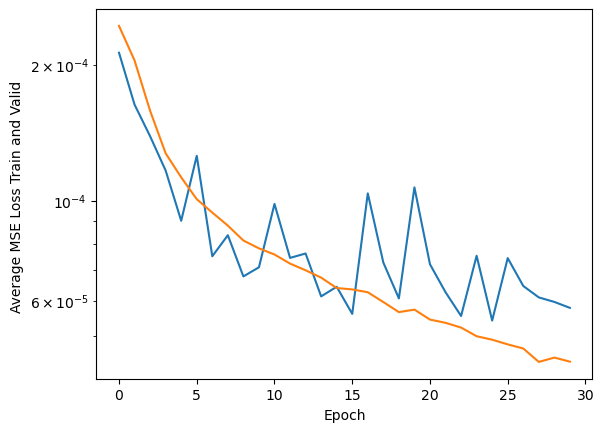

In [46]:
plt.figure()
plt.semilogy(valid_losses, label='valid')
plt.semilogy(train_losses, label='train')
plt.xlabel('Epoch')
plt.ylabel('Average MSE Loss Train and Valid ')

* Here I've first evaluated the bestmodel on the validation dataset, Latter I've flatten the true and pred masses of the dark matter Halo.

In [47]:
def evaluate(val_loader):
    
    model.eval()
    loss = 0 
    pred_mass = [ ]
    true_mass = [ ]
    
    with torch.no_grad():
        for i , ( img , y ) in tqdm(enumerate(val_loader) , total=(len(val_loader))):
            if device == 'cuda':
                img = img.type(torch.cuda.FloatTensor)
            else:
                img = img.type(torch.FloatTensor)
            y =y.to(device)
            y_true = y
            true_mass.append(y_true.detach().cpu().numpy())
      
            score = model(img)
            score = score.view(len(score))
            pred = score
            pred_mass.append(score.detach().cpu().numpy())
            l = criterion(score , y)
            loss+= l 
       
        loss = loss/(i+1)
        return pred_mass , true_mass


pred_mass , true_mass = evaluate(valid_loader)

predict = []
actual_mass = []
def flatten_numpy(x , y): 
    for i in y:
        for j in i:
            x.append(j)
flatten_numpy(predict , pred_mass) 
flatten_numpy(actual_mass , true_mass)

100%|██████████| 63/63 [00:04<00:00, 13.72it/s]


* **Ploting the scattered graph for pred_masses and true_masses**

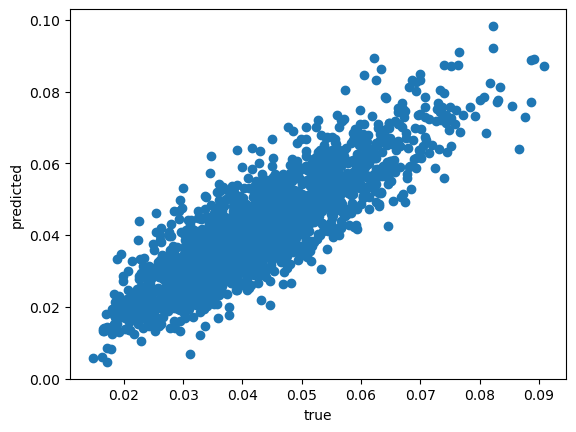

In [48]:
plt.scatter(predict , actual_mass) 
plt.xlabel("true")
plt.ylabel("predicted")
plt.show()

* Conclusion


The current model can predict the masses with a loss of 5.4e-5.
I've tried to train various model as mentioned in the *Model* section and really think the model can be further improved, I also tried to built a resnet from scratch but with Mish activation( I really wanted to use it :) ) but it gave large zig-zag like losses, I didn't tried to further fine tune it, cause I wanted to send the solutions as soon as possible, so that I can take time to know more about the projects and create a good proposal ✌😊.

*Reference*

[Deep Learning The Morphology of Dark Matter Substructure](https://arxiv.org/abs/1909.07346/)

[Mish activation](https://arxiv.org/abs/1908.08681#:~:text=We%20propose%20%5Ctextit%7BMish%7D,tanh(softplus(x)))